In [1]:
import numpy as np 
import pandas as pd
from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from matplotlib import pyplot as plt 
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering 

# Carga de datos

In [2]:
filename = 'cars_clus.csv'
pdf = pd.read_csv(filename)
print ("Forma del set de datos: ", pdf.shape)
pdf.head(5)

Forma del set de datos:  (159, 16)


,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.000,21.500,1.800,140.000,101.200,67.300,172.400,2.639,13.200,28.000,2.828,0.0
1,Acura,TL,39.384,19.875,0.000,28.400,3.200,225.000,108.100,70.300,192.900,3.517,17.200,25.000,3.673,0.0
2,Acura,CL,14.114,18.225,0.000,$null$,3.200,225.000,106.900,70.600,192.000,3.470,17.200,26.000,2.647,0.0
3,Acura,RL,8.588,29.725,0.000,42.000,3.500,210.000,114.600,71.400,196.600,3.850,18.000,22.000,2.150,0.0
4,Audi,A4,20.397,22.255,0.000,23.990,1.800,150.000,102.600,68.200,178.000,2.998,16.400,27.000,3.015,0.0


In [3]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   manufact   157 non-null    object 
 1   model      159 non-null    object 
 2   sales      159 non-null    object 
 3   resale     159 non-null    object 
 4   type       159 non-null    object 
 5   price      159 non-null    object 
 6   engine_s   159 non-null    object 
 7   horsepow   159 non-null    object 
 8   wheelbas   159 non-null    object 
 9   width      159 non-null    object 
 10  length     159 non-null    object 
 11  curb_wgt   159 non-null    object 
 12  fuel_cap   159 non-null    object 
 13  mpg        159 non-null    object 
 14  lnsales    159 non-null    object 
 15  partition  159 non-null    float64
dtypes: float64(1), object(15)
memory usage: 20.0+ KB


# Limpieza de Datos

In [4]:
# Elimina filas que tienen valores nulos:    
print ("Shape of dataset before cleaning: ", pdf.size)
pdf[[ 'sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']] = pdf[['sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']].apply(pd.to_numeric, errors='coerce')
pdf = pdf.dropna()
pdf = pdf.reset_index(drop=True)
print ("Forma del dataset luego de la limpieza: ", pdf.size)
pdf.head(5)

Shape of dataset before cleaning:  2544
Forma del dataset luego de la limpieza:  1872


,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0.0
1,Acura,TL,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0
2,Acura,RL,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0.0
3,Audi,A4,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,0.0
4,Audi,A6,18.780,23.555,0.0,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933,0.0


In [5]:
# selecciono caraceristicas a analizar
featureset = pdf[['engine_s',  'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap', 'mpg']]

In [6]:
# normalilzación de datos (0-1)
from sklearn.preprocessing import MinMaxScaler
x = featureset.values 
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)
feature_mtx [0:5]

array([[0.11428571, 0.21518987, 0.18655098, 0.28143713, 0.30625832,
        0.2310559 , 0.13364055, 0.43333333],
       [0.31428571, 0.43037975, 0.3362256 , 0.46107784, 0.5792277 ,
        0.50372671, 0.31797235, 0.33333333],
       [0.35714286, 0.39240506, 0.47722343, 0.52694611, 0.62849534,
        0.60714286, 0.35483871, 0.23333333],
       [0.11428571, 0.24050633, 0.21691974, 0.33532934, 0.38082557,
        0.34254658, 0.28110599, 0.4       ],
       [0.25714286, 0.36708861, 0.34924078, 0.80838323, 0.56724368,
        0.5173913 , 0.37788018, 0.23333333]])

In [7]:
# Calculo matriz distancia
import scipy
leng = feature_mtx.shape[0]
D = scipy.zeros([leng,leng])
for i in range(leng):
    for j in range(leng):
        D[i,j] = scipy.spatial.distance.euclidean(feature_mtx[i], feature_mtx[j])

C:\Users\Paulina Males\AppData\Local\Temp\ipykernel_18140\3581635442.py:4: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([leng,leng])


In [8]:
# metodo que complementa el calculod e la distancia
import pylab
import scipy.cluster.hierarchy
Z = hierarchy.linkage(D, 'complete')

# especificaciones, asignacion e numero de clusters
from scipy.cluster.hierarchy import fcluster
k = 5
clusters = fcluster(Z, k, criterion='maxclust')
clusters

C:\Users\Paulina Males\AppData\Local\Temp\ipykernel_18140\3268404178.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(D, 'complete')


array([1, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 1, 3, 3, 3, 3, 2, 1,
       5, 3, 3, 3, 3, 3, 1, 3, 3, 4, 4, 4, 4, 2, 3, 1, 3, 3, 3, 2, 3, 2,
       4, 3, 4, 1, 3, 3, 3, 2, 1, 1, 3, 3, 1, 3, 3, 3, 3, 2, 2, 2, 1, 3,
       3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 1, 3, 3, 3, 3, 3, 2,
       3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1,
       3, 4, 1, 1, 3, 1, 1], dtype=int32)

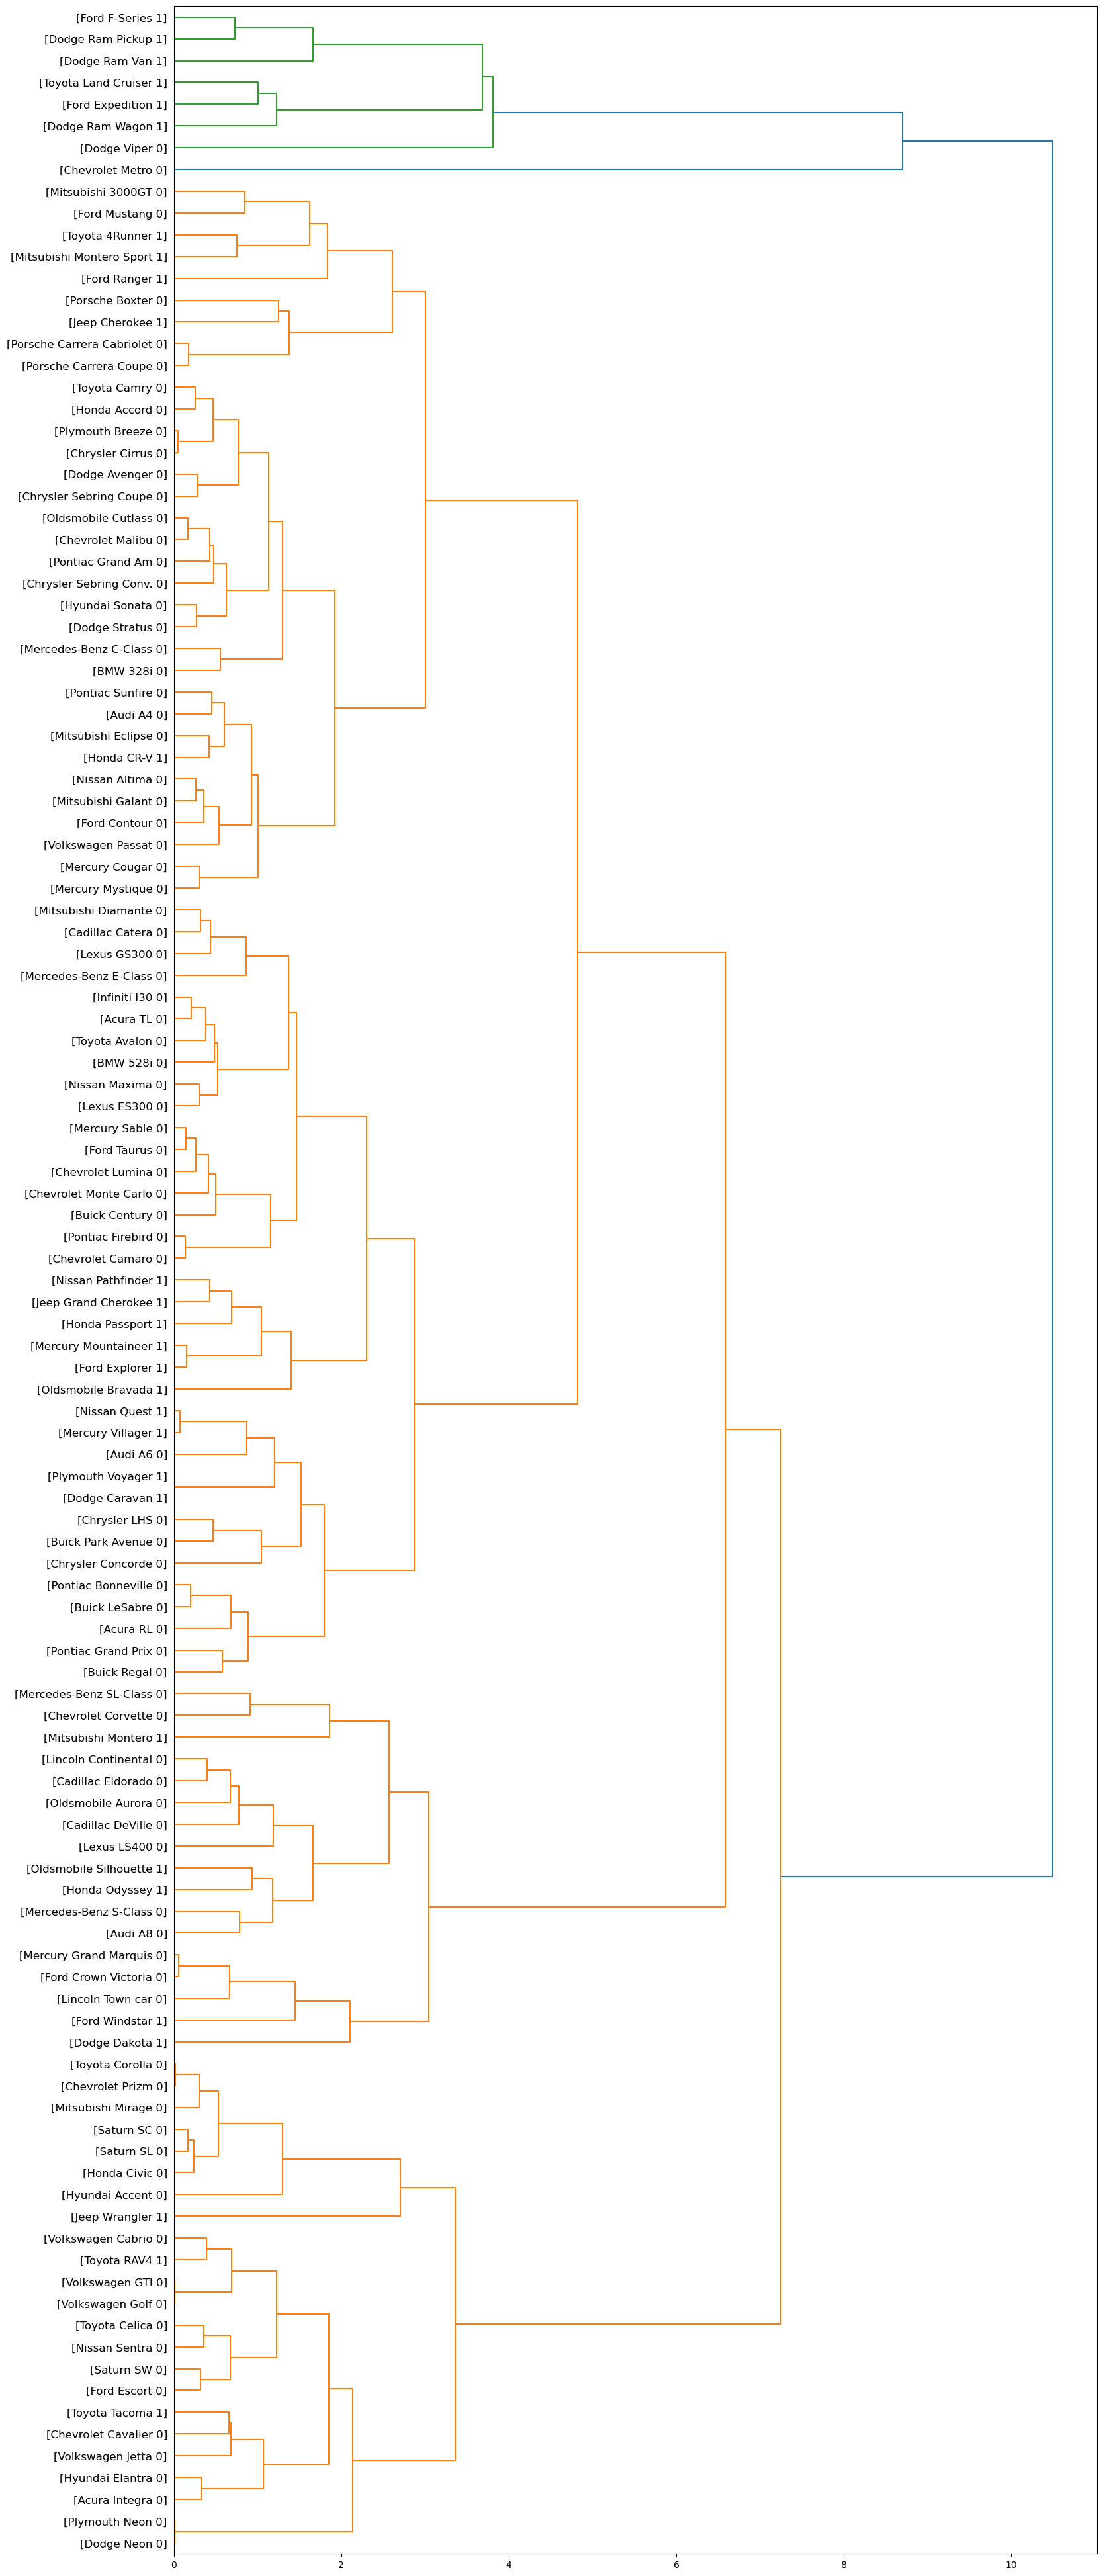

In [9]:
# Trazo del denograma
fig = pylab.figure(figsize=(18,50))
def llf(id):
    return '[%s %s %s]' % (pdf['manufact'][id], pdf['model'][id], int(float(pdf['type'][id])) )

dendro = hierarchy.dendrogram(Z,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'right')